# Previsão de Renda Anual

## Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import pickle 
import shap

from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Funções
def countplot(x):
    print(data[x].value_counts(normalize = True).round(2))
    plt.figure(figsize=(10,7))
    sns.countplot(data = data, y = x, order = data[x].value_counts().index, palette = 'BrBG_r')
    plt.title(x)
    plt.show()

def quantitativas(x):
    print(data[x].describe())
    fig, axs = plt.subplots(ncols = 2, figsize=(18,8))
    sns.distplot(data[x], kde = False, norm_hist=True, ax = axs[0])
    sns.boxplot(data = data, y = x, ax = axs[1])

def relacao_target(x):
    print(pd.crosstab(data[x], data['over50k'], normalize = 'index').reset_index().sort_values('>50K', ascending = False))
    plt.figure(figsize = (13, 8))
    sns.countplot(data = data, x = x, hue = 'over50k', order = data[x].value_counts().index, palette = 'BrBG_r')

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)
    
def print_ecdf(x):
    plt.figure(figsize = (10, 8))
    rand_normal1 = data[x]
    x,y = ecdf(rand_normal1)  
    plt.scatter(x = x, y = y)
    plt.ylabel('Distribuição da Base', fontsize = 12)

###############################################

def treina_testa_modelo(metrica):
    # Testa a performance do modelo base
    # Preparando a lista de modelos
    modelos = []
    modelos.append(('LogisticRegression', LogisticRegression()))
    modelos.append(('KNeighborsClassifier', KNeighborsClassifier()))
    modelos.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    modelos.append(('RandomForestClassifier', RandomForestClassifier()))
    modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier()))

    # Avaliando cada modelo em um loop
    resultados = []
    nomes = []

    for nome, modelo in modelos:
        kfold = KFold(n_splits = 10, random_state = 1)
        cv_results = cross_val_score(modelo, x, y, cv = kfold, scoring = metrica)
        resultados.append(cv_results)
        nomes.append(nome)
        msg = '%s: %f (%f)' % (nome, cv_results.mean(), cv_results.std())
        print(msg)

## Importação do dataset

In [3]:
data = pd.read_csv('census_v11.csv', delimiter = ';')
data.sample(5)

,age,workclass,education,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,over50k
16070,34,Local-gov,Masters,Married-civ-spouse,Prof-specialty,_husband_,Black,Male,0,0,40,United-States,<=50K
6159,59,Private,Doctorate,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
19104,26,State-gov,Some-college,Married-civ-spouse,Exec-managerial,_husband_,White,Male,0,0,12,United-States,<=50K
28409,31,Private,Some-college,Married-civ-spouse,Sales,Husband,White,Male,15024,0,45,United-States,>50K
26757,59,State-gov,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K


Variáveis:
- age: Idade;
- workclass: Categoria da empresa em que trabalha;
- education: Grau de educação;
- maritalstatus: Estado civil;
- occupation: Área de atuação;
- relationship: Status na família;
- race: Raça;
- sex: Sexo;
- capitalgain: Ganho de capital no ano;
- capitalloss: Perda de capital no ano;
- hoursperweek: Horas trabalhadas por semana;
- nativecountry: País de origem;
- over50k: Salário anual (target)

## Resumo do dataset

In [4]:
# Tamanho do dataset
data.shape

(31978, 13)

In [5]:
# Verifica tipos de variáveis
data.dtypes

age               int64
workclass        object
education        object
maritalstatus    object
occupation       object
relationship     object
race             object
sex              object
capitalgain       int64
capitalloss       int64
hoursperweek      int64
nativecountry    object
over50k          object
dtype: object

In [6]:
# Verifica linhas vazias
data.isnull().sum()

age              0
workclass        0
education        0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
nativecountry    0
over50k          0
dtype: int64

In [7]:
# Dropa espaços em branco, uma vez que todas variáveis categóricas são separadas por '-'
data['over50k'] = data['over50k'].str.lstrip()
data['workclass'] = data['workclass'].str.lstrip()
data['education'] = data['education'].str.lstrip()
data['maritalstatus'] = data['maritalstatus'].str.lstrip()
data['occupation'] = data['occupation'].str.lstrip()
data['relationship'] = data['relationship'].str.lstrip()
data['race'] = data['race'].str.lstrip()
data['sex'] = data['sex'].str.lstrip()
data['nativecountry'] = data['nativecountry'].str.lstrip()
data['over50k'] = data['over50k'].str.lstrip()

# Análise Exploratória e Tratamento de Variáveis

## Variáveis Categóricas

Private             0.74
Self-emp-not-inc    0.08
Local-gov           0.07
State-gov           0.04
Self-emp-inc        0.04
Federal-gov         0.03
Without-pay         0.00
Never-worked        0.00
Name: workclass, dtype: float64


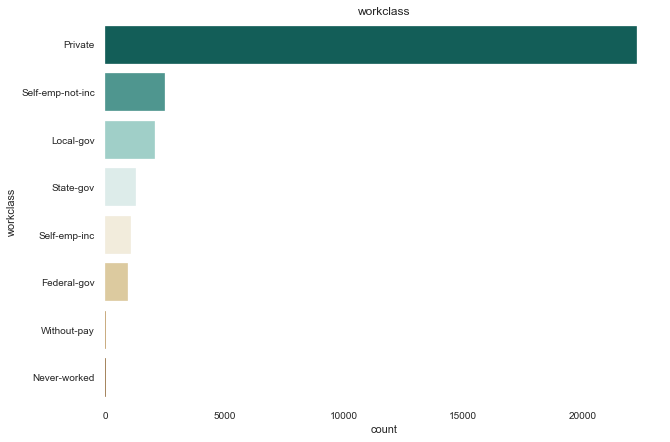

In [8]:
# Workclass
data = data[data['workclass'] != '?']
countplot('workclass')

HS-grad         0.33
Some-college    0.22
Bachelors       0.17
Masters         0.05
Assoc-voc       0.04
11th            0.03
Assoc-acdm      0.03
10th            0.03
7th-8th         0.02
Prof-school     0.02
9th             0.02
12th            0.01
Doctorate       0.01
5th-6th         0.01
1st-4th         0.01
Preschool       0.00
Name: education, dtype: float64


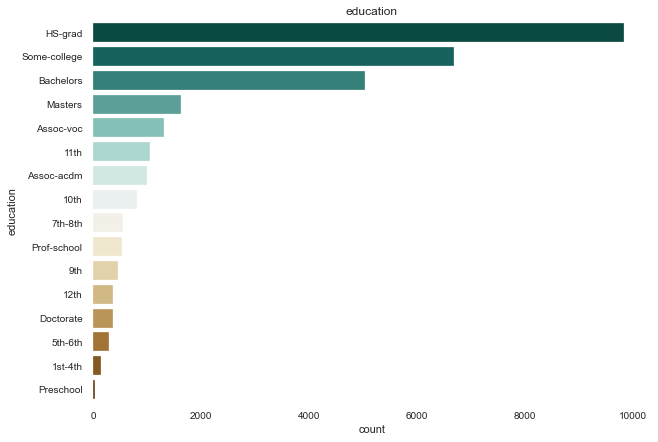

In [9]:
# education
countplot('education')

Married-civ-spouse       0.47
Never-married            0.32
Divorced                 0.14
Separated                0.03
Widowed                  0.03
Married-spouse-absent    0.01
Married-AF-spouse        0.00
Name: maritalstatus, dtype: float64


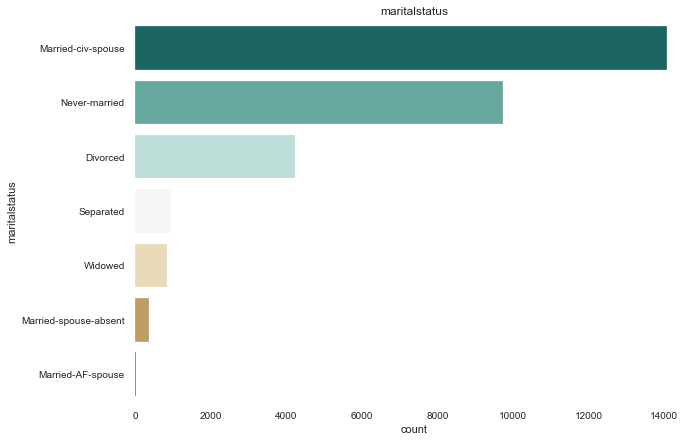

In [10]:
# maritalstatus
countplot('maritalstatus')

Prof-specialty       0.13
Craft-repair         0.13
Exec-managerial      0.13
Adm-clerical         0.12
Sales                0.12
Other-service        0.11
Machine-op-inspct    0.07
Transport-moving     0.05
Handlers-cleaners    0.04
Farming-fishing      0.03
Tech-support         0.03
Protective-serv      0.02
Priv-house-serv      0.00
Armed-Forces         0.00
Name: occupation, dtype: float64


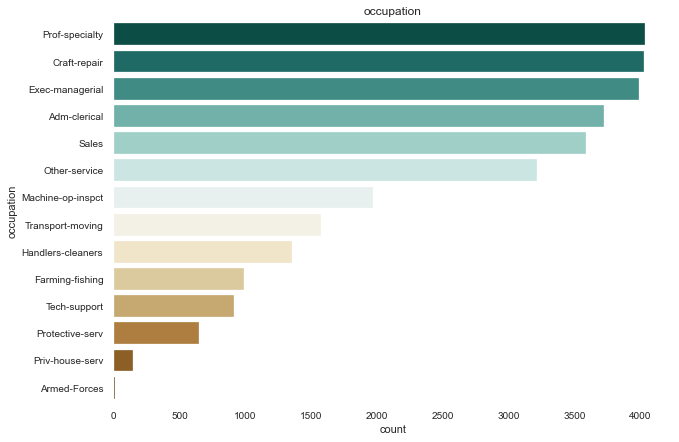

In [11]:
# occupation
data = data[data['occupation'] != '?']
countplot('occupation')

Husband           0.41
Not-in-family     0.26
Own-child         0.15
Unmarried         0.11
Wife              0.05
Other-relative    0.03
Name: relationship, dtype: float64


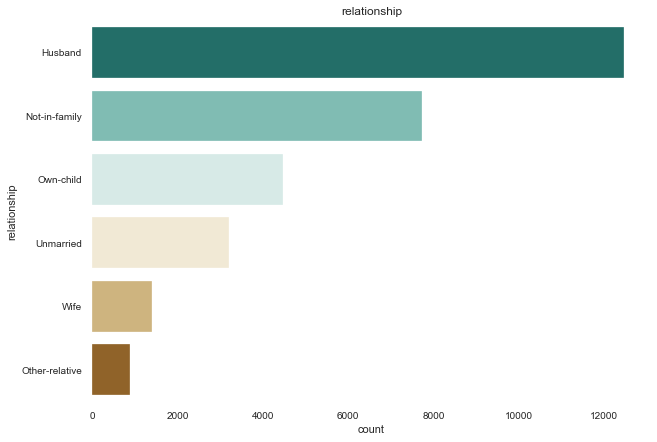

In [12]:
# relationship
data['relationship'] = np.where(data['relationship'] == '_wife_', 'Wife', data['relationship'])
data['relationship'] = np.where(data['relationship'] == '_husband_', 'Husband', data['relationship'])
countplot('relationship')

White                 0.86
Black                 0.09
Asian-Pac-Islander    0.03
Amer-Indian-Eskimo    0.01
Other                 0.01
Name: race, dtype: float64


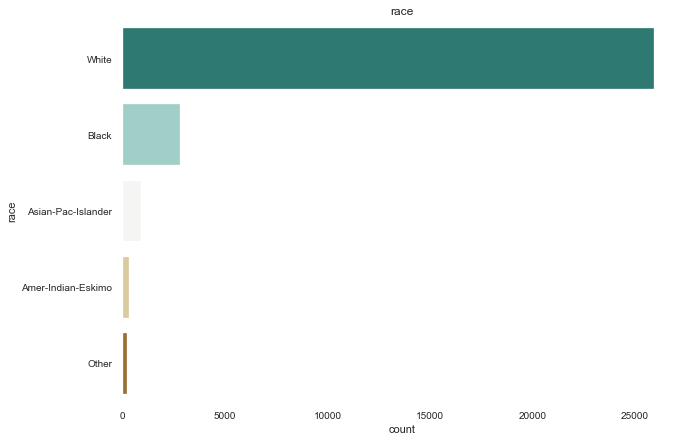

In [13]:
# race
countplot('race')

Male      0.68
Female    0.32
Name: sex, dtype: float64


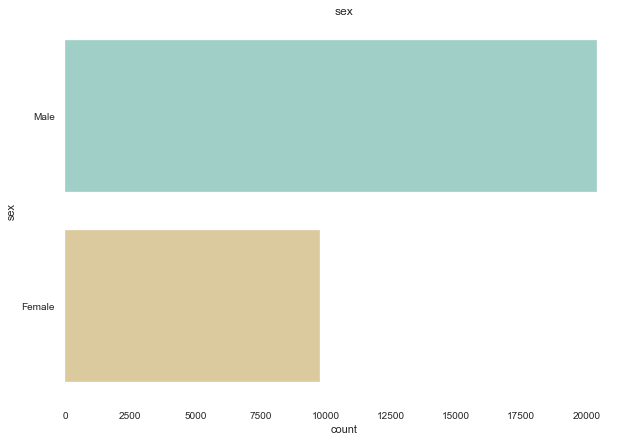

In [14]:
# sex
countplot('sex')

United-States    0.91
Other            0.06
Mexico           0.02
Philippines      0.01
Name: nativecountry, dtype: float64


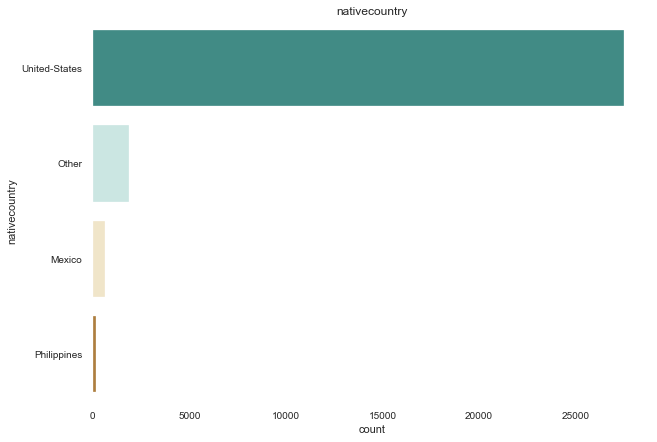

In [15]:
# nativecountry
data['nativecountry'] = np.where((data['nativecountry'] != 'United-States') & 
                                 (data['nativecountry'] != 'Mexico') &
                                 (data['nativecountry'] != 'Philippines'), 'Other', data['nativecountry'])
countplot('nativecountry')
# Agrupar o que for diferente de United-States e Mexico

<=50K    0.75
>50K     0.25
Name: over50k, dtype: float64


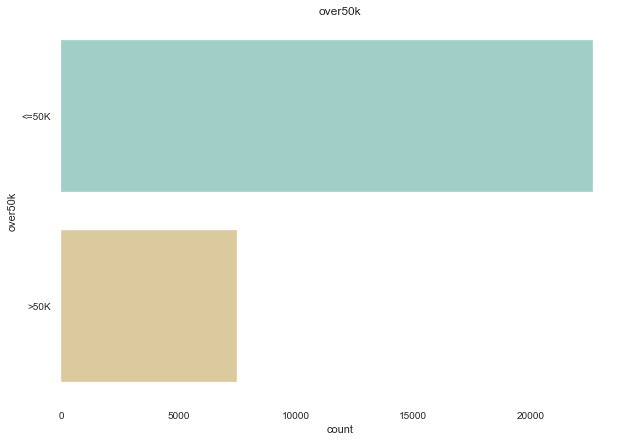

In [16]:
# over50k
countplot('over50k')

In [17]:
# Verifica o shape após a remoção das variáveis '?'
data.shape

(30162, 13)

## Variáveis Numéricas

count    30162.000000
mean        38.437902
std         13.134665
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64


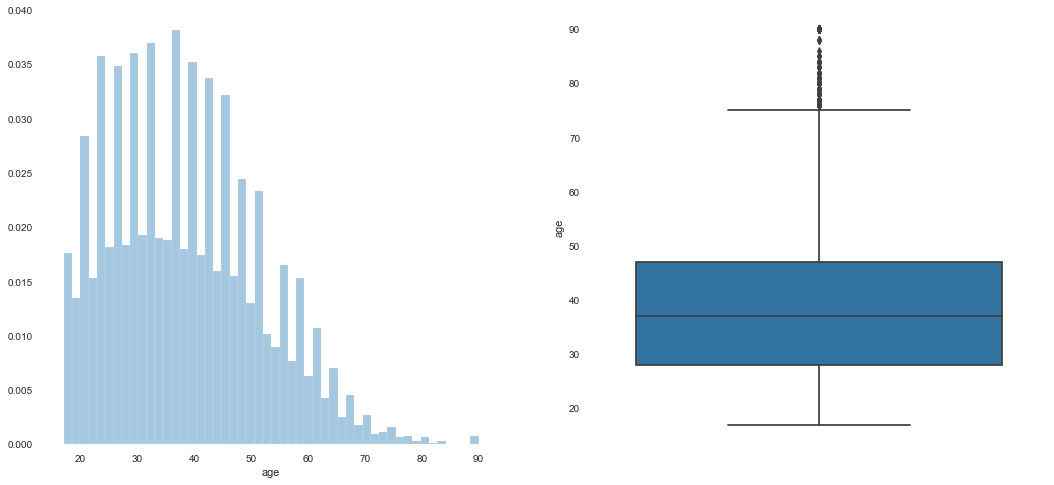

In [18]:
# Age
quantitativas('age')

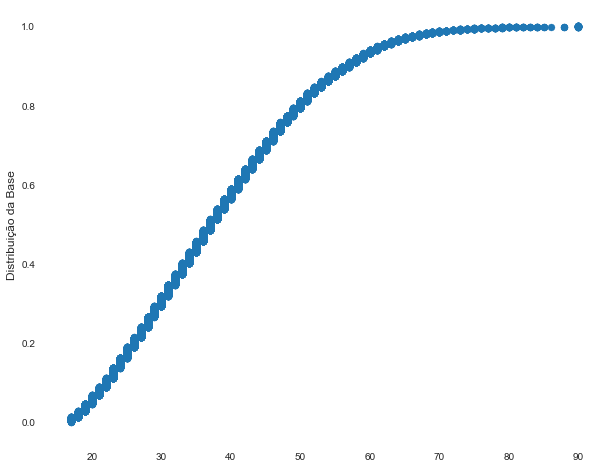

In [19]:
print_ecdf('age')

count    30162.000000
mean        40.931238
std         11.979984
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hoursperweek, dtype: float64


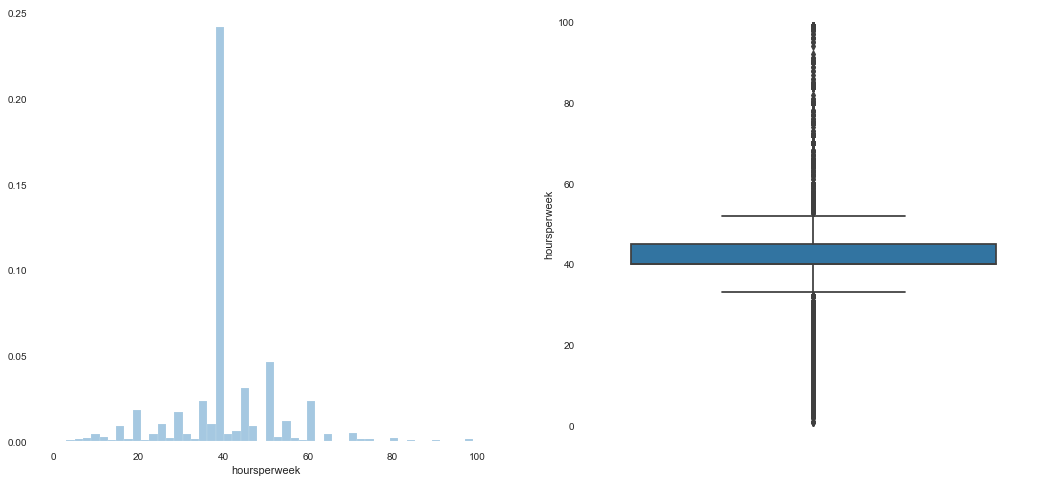

In [20]:
# hoursperweek
quantitativas('hoursperweek')
# Manter mesmo com outliers por entender que fazem parte do negócio

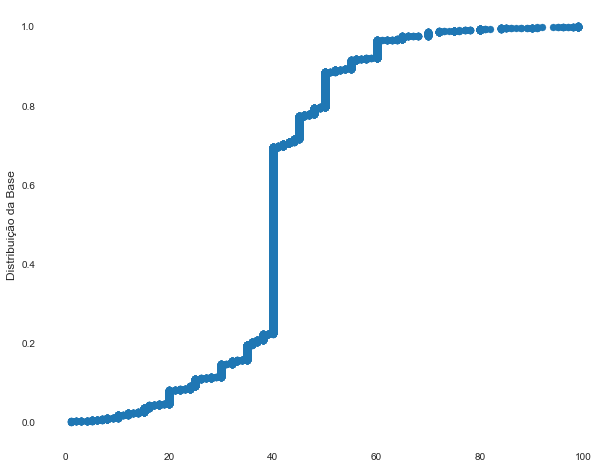

In [21]:
print_ecdf('hoursperweek')

In [22]:
# capitalgain
data['capitalgain'].describe()
# Remover

count    30162.000000
mean      1092.007858
std       7406.346497
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capitalgain, dtype: float64

In [23]:
# capitalloss
data['capitalloss'].describe()
# Remover

count    30162.000000
mean        88.372489
std        404.298370
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capitalloss, dtype: float64

## Relação com Target

over50k         workclass     <=50K      >50K
3            Self-emp-inc  0.441341  0.558659
0             Federal-gov  0.612937  0.387063
1               Local-gov  0.705370  0.294630
4        Self-emp-not-inc  0.714286  0.285714
5               State-gov  0.731040  0.268960
2                 Private  0.781208  0.218792
6             Without-pay  1.000000  0.000000


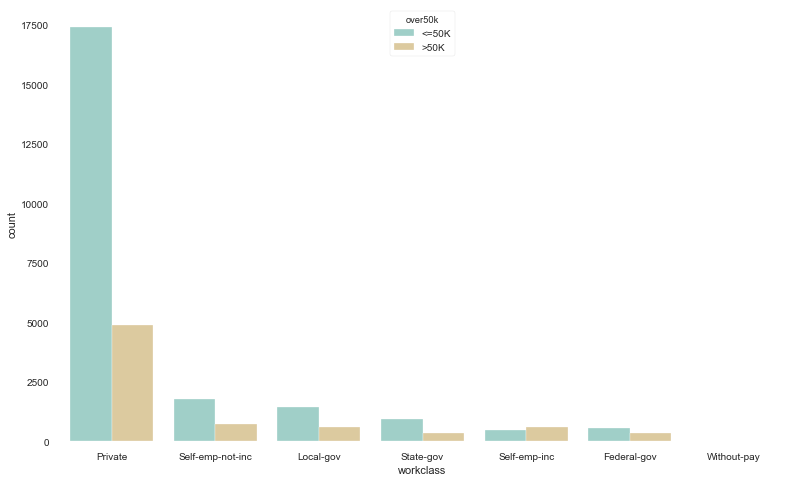

In [24]:
# workclass
relacao_target('workclass')

over50k     education     <=50K      >50K
14        Prof-school  0.250923  0.749077
10          Doctorate  0.253333  0.746667
12            Masters  0.435771  0.564229
9           Bachelors  0.578509  0.421491
8           Assoc-voc  0.736802  0.263198
7          Assoc-acdm  0.746032  0.253968
15       Some-college  0.799940  0.200060
11            HS-grad  0.835671  0.164329
2                12th  0.923077  0.076923
0                10th  0.928049  0.071951
5             7th-8th  0.937163  0.062837
1                11th  0.943702  0.056298
6                 9th  0.945055  0.054945
4             5th-6th  0.958333  0.041667
3             1st-4th  0.960265  0.039735
13          Preschool  1.000000  0.000000


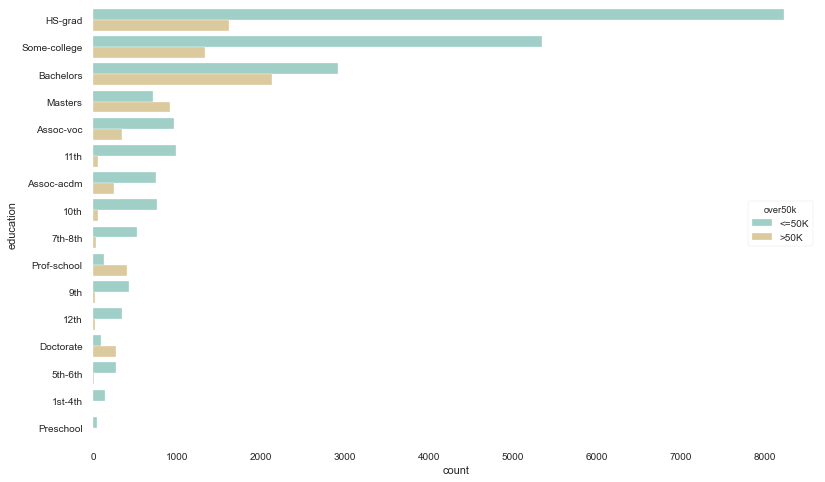

In [48]:
# education
print(pd.crosstab(data['education'], data['over50k'], normalize = 'index').reset_index().sort_values('>50K', ascending = False))
plt.figure(figsize = (13, 8))
sns.countplot(data = data, y = 'education', hue = 'over50k', order = data['education'].value_counts().index, palette = 'BrBG_r')

over50k          maritalstatus     <=50K      >50K
1            Married-AF-spouse  0.523810  0.476190
2           Married-civ-spouse  0.545041  0.454959
0                     Divorced  0.892738  0.107262
6                      Widowed  0.903265  0.096735
3        Married-spouse-absent  0.916216  0.083784
5                    Separated  0.929712  0.070288
4                Never-married  0.951676  0.048324


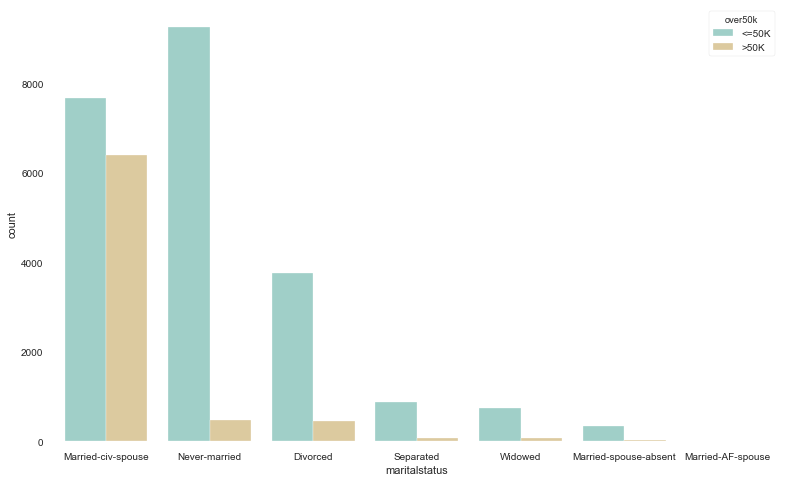

In [26]:
# maritalstatus
relacao_target('maritalstatus')

over50k         occupation     <=50K      >50K
3          Exec-managerial  0.514780  0.485220
9           Prof-specialty  0.551511  0.448489
10         Protective-serv  0.673913  0.326087
12            Tech-support  0.695175  0.304825
11                   Sales  0.729353  0.270647
2             Craft-repair  0.774690  0.225310
13        Transport-moving  0.797074  0.202926
0             Adm-clerical  0.866165  0.133835
6        Machine-op-inspct  0.875381  0.124619
4          Farming-fishing  0.883721  0.116279
1             Armed-Forces  0.888889  0.111111
5        Handlers-cleaners  0.938519  0.061481
7            Other-service  0.958904  0.041096
8          Priv-house-serv  0.993007  0.006993


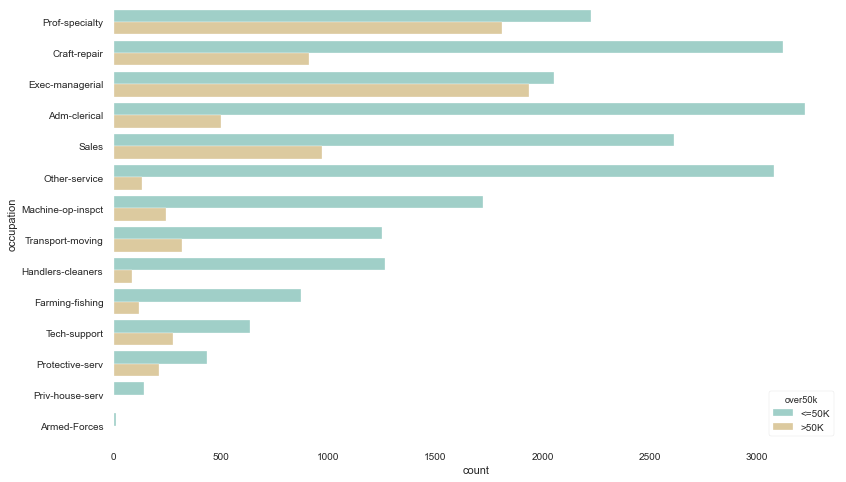

In [47]:
# occupation
print(pd.crosstab(data['occupation'], data['over50k'], normalize = 'index').reset_index().sort_values('>50K', ascending = False))
plt.figure(figsize = (13, 8))
sns.countplot(data = data, y = 'occupation', hue = 'over50k', order = data['occupation'].value_counts().index, palette = 'BrBG_r')

over50k    relationship     <=50K      >50K
5                  Wife  0.506401  0.493599
0               Husband  0.544331  0.455669
1         Not-in-family  0.893477  0.106523
4             Unmarried  0.933686  0.066314
2        Other-relative  0.960630  0.039370
3             Own-child  0.985670  0.014330


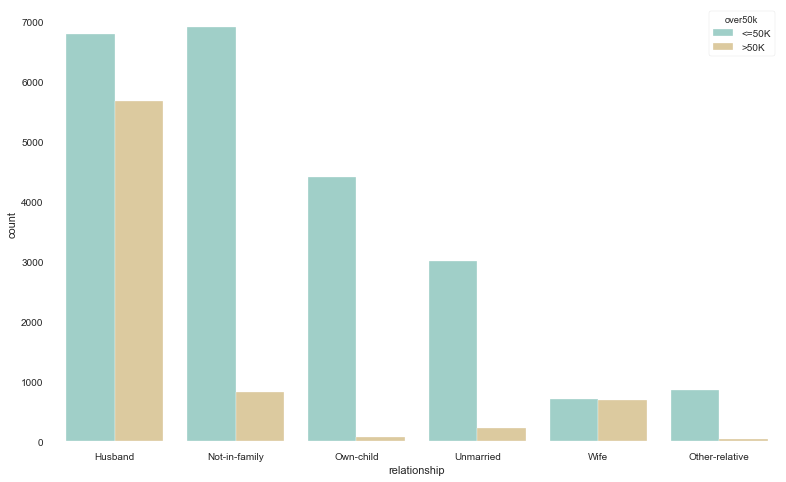

In [28]:
# relationship
relacao_target('relationship')

over50k                race     <=50K      >50K
1        Asian-Pac-Islander  0.722905  0.277095
4                     White  0.736282  0.263718
2                     Black  0.870075  0.129925
0        Amer-Indian-Eskimo  0.881119  0.118881
3                     Other  0.909091  0.090909


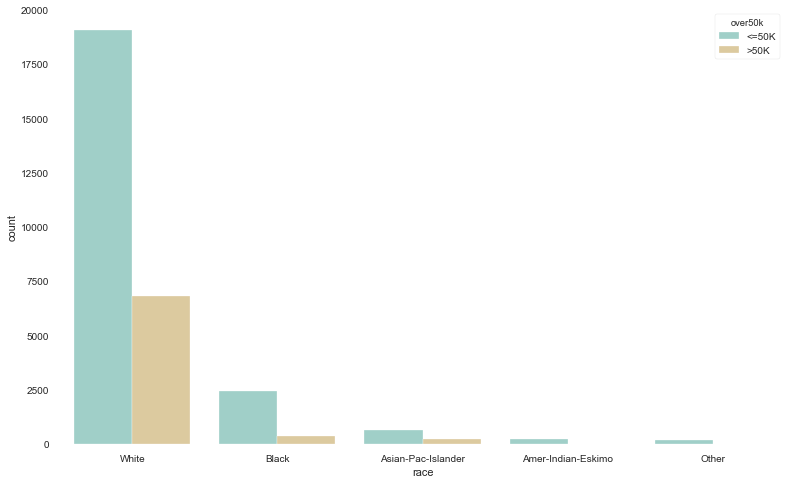

In [29]:
# sex
relacao_target('race')

over50k     sex     <=50K      >50K
1          Male  0.686163  0.313837
0        Female  0.886322  0.113678


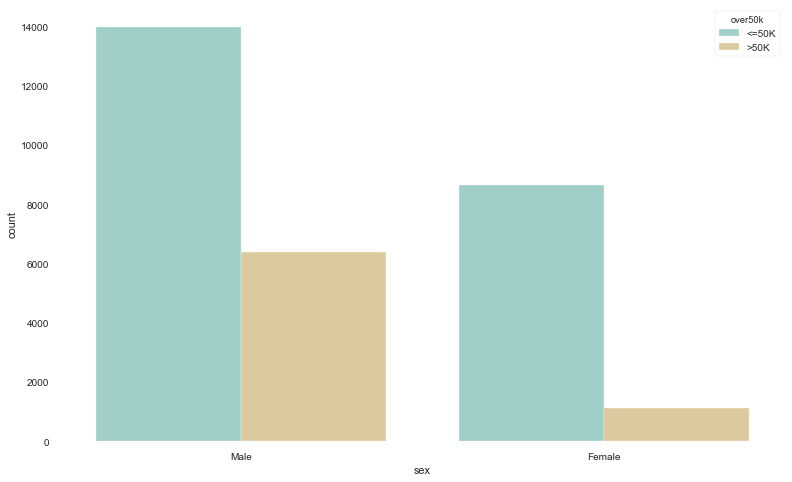

In [30]:
# sex
relacao_target('sex')

over50k  nativecountry     <=50K      >50K
2          Philippines  0.680851  0.319149
3        United-States  0.745673  0.254327
1                Other  0.774194  0.225806
0               Mexico  0.945902  0.054098


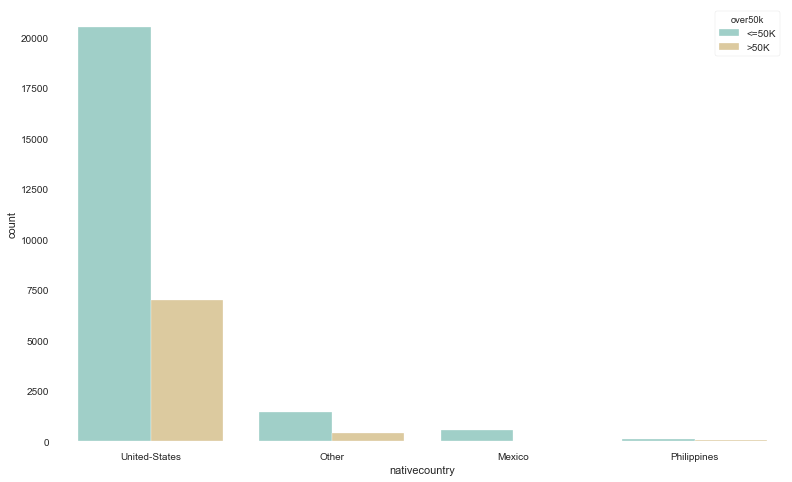

In [31]:
# nativecountry
relacao_target('nativecountry')

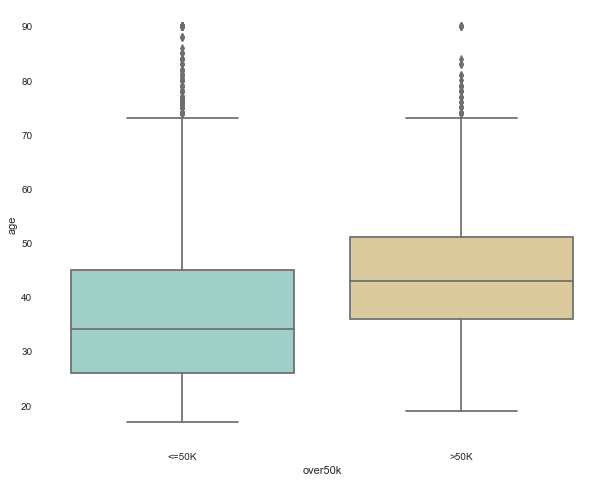

In [32]:
# age
plt.figure(figsize = (10, 8))
sns.boxplot(data = data, x = 'over50k', y = 'age', palette = 'BrBG_r')

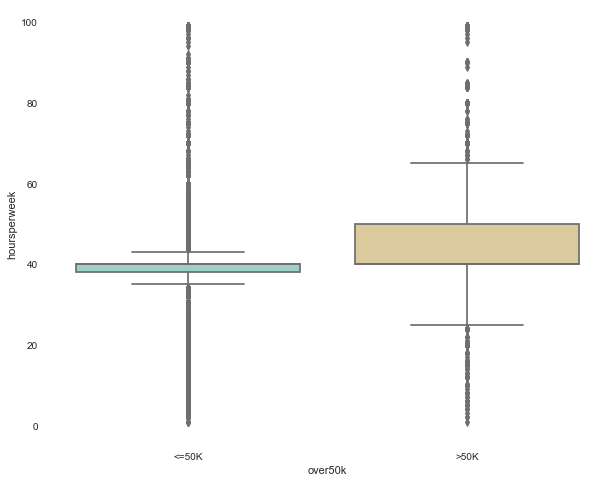

In [33]:
# hoursperweek

plt.figure(figsize = (10, 8))
sns.boxplot(data = data, x = 'over50k', y = 'hoursperweek', palette = 'BrBG_r')

# Modelagem Preditiva

In [34]:
# Iremos deletar as variáveis 'capitalgain' e 'capitalloss' pois mais de 90% está vazia, além da relationship por entender que a mesma possui a mesma informação da maritalstatus
del data['capitalgain']
del data['capitalloss']
del data['relationship']

In [35]:
# Separa as variáveis preditoras e target
x = data.iloc[:, 0:8]
y = data.iloc[:, 9]

# Binariza o target
y = np.where(y == '>50K', 1, 0)

In [36]:
# Transforma as variáveis preditoras em dummy
x = pd.get_dummies(x)
x.sample(3)

,age,hoursperweek,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
10705,39,40,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
10584,58,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
14441,30,35,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [37]:
# Testa a performance do modelo com f1
treina_testa_modelo('f1')

LogisticRegression: 0.618170 (0.014298)
KNeighborsClassifier: 0.581155 (0.017727)
DecisionTreeClassifier: 0.553303 (0.014512)
RandomForestClassifier: 0.603067 (0.013398)
GradientBoostingClassifier: 0.627141 (0.011314)


In [38]:
# Testa a performance do modelo com AUC
treina_testa_modelo('roc_auc')

LogisticRegression: 0.879128 (0.007201)
KNeighborsClassifier: 0.817435 (0.009417)
DecisionTreeClassifier: 0.731140 (0.007733)
RandomForestClassifier: 0.857024 (0.006693)
GradientBoostingClassifier: 0.889096 (0.006281)


# Hyperparameter tunning no Gradient Boosting

In [39]:
# Separação entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1)

# Cria um dicionário com os hyperparâmetros e modelos que serão testados;
search_space = [{"n_estimators": [5, 10, 100, 500, 1000],
                "max_depth":[5, 8, 15, 25, 30, 50, 100, None],
                "min_samples_leaf":[1, 2, 5, 10, 15, 30, 50, 100], 
                " max_leaf_nodes": [2, 5, 10, 15, 30]
                 }] 

modelo = GradientBoostingClassifier()

# Cria o tunner
rsearch = RandomizedSearchCV(estimator = modelo,
                            param_distributions = search_space,
                            n_iter = 14,
                            random_state = 1)

best_model = rsearch.fit(x_train, y_train)

print(best_model.best_estimator_)

GradientBoostingClassifier(max_depth=15, max_leaf_nodes=10, min_samples_leaf=30,
                           n_estimators=500)


In [40]:
# Cria o modelo com os parâmetros definidos pelo hyperparameter tunning e testa com cross-validation
modelo = GradientBoostingClassifier(max_depth=15, 
                                    max_leaf_nodes=10, 
                                    min_samples_leaf=30,
                                    n_estimators=500).fit(x_train, y_train)
y_pred = modelo.predict(x_test)
y_proba = modelo.predict_proba(x_test)[::,1]


print(classification_report(y_test, y_pred, target_names = ['<= 50k', '> 50k']))
print('\n')

roc_auc = cross_val_score(modelo, x_test, y_test, cv = 10, scoring = 'roc_auc')
print('Lista CV - ROC_AUC: ' + str(roc_auc.round(2)))
print('Média - ROC_AUC: '+ str(roc_auc.mean().round(2)))
print('\n')
f1 = cross_val_score(modelo, x_test, y_test, cv = 10, scoring = 'f1')
print('Lista CV - F1: ' + str(f1.round(2)))
print('Média - F1: '+ str(f1.mean().round(2)))

              precision    recall  f1-score   support

      <= 50k       0.87      0.92      0.90      5642
       > 50k       0.73      0.60      0.66      1899

    accuracy                           0.84      7541
   macro avg       0.80      0.76      0.78      7541
weighted avg       0.84      0.84      0.84      7541



Lista CV - ROC_AUC: [0.89 0.87 0.9  0.88 0.9  0.87 0.9  0.87 0.89 0.89]
Média - ROC_AUC: 0.88


Lista CV - F1: [0.66 0.6  0.65 0.64 0.68 0.63 0.68 0.63 0.67 0.64]
Média - F1: 0.65


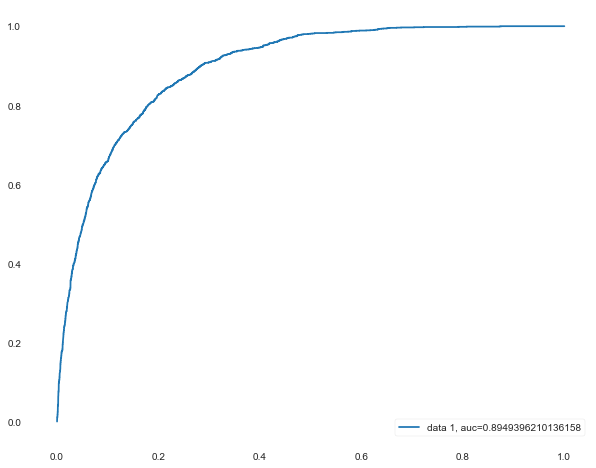

In [41]:
# Print da curva AUC
fpr, tpr, _ = roc_curve(y_test,  y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize = (10, 8))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Salvar o artefato do modelo

In [42]:
filename = 'RendaPrevista_GB_v1.sav'
pickle.dump(modelo, open(filename, 'wb'))

# Explicação do Modelo

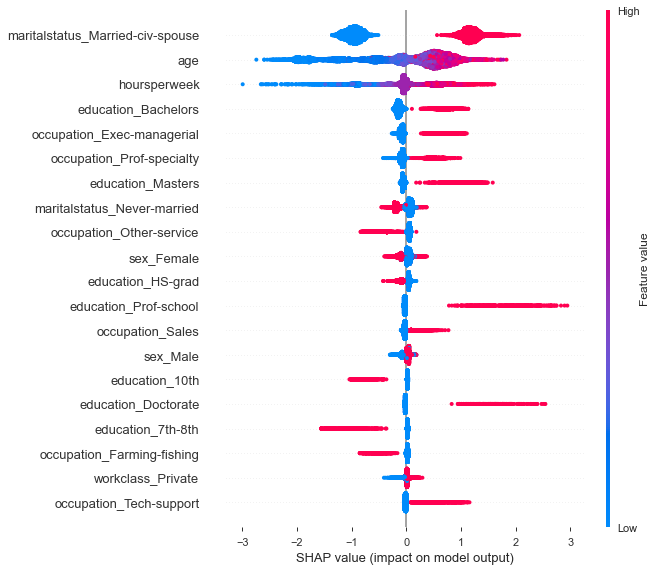

In [44]:
# Rotula a base
X = pd.DataFrame(x_train)
X.columns = x_train.columns

# Cria o explainer
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)